In [58]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import minimize
import sunpy.map
import glob

from data_process.aia_part.get_aia_simu import get_aia_simu
from data_process.aia_part.get_aia_simu_5 import get_aia_simu_5
from data_process.error_function import error_function

In [2]:
eve_frame=pd.read_csv('data_process/eve_part/data/daily_date.csv')

date=[]
for i in eve_frame['date']:
    date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))
    
eve_frame['date']=date
eve_frame=eve_frame.set_index('date')

# EVE

In [35]:
frame=pd.read_csv('data_process/eve_part/data/daily_date.csv')

date=[]
for i in frame['date']:
    date.append(datetime.datetime.strptime(i, '%Y-%m-%d'))
    
frame['date']=date
frame=frame.set_index('date')
frame.head()

daily_mean  daily_stddev
date                                
2011-01-11   30.374087      0.000191
2011-01-12   30.374090      0.000170
2011-01-13   30.374055      0.000182
2011-01-14   30.374055      0.000181
2011-01-15   30.374071      0.000179

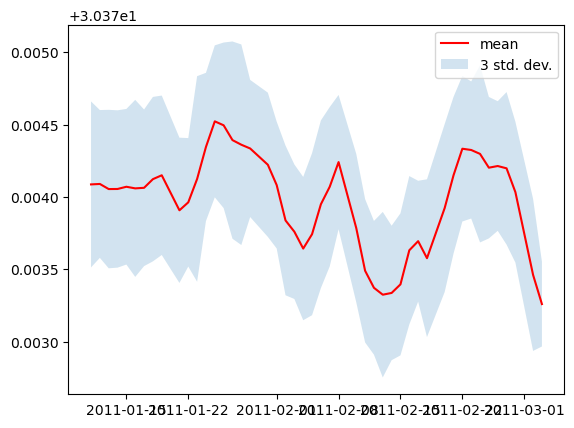

In [6]:
fig,ax=plt.subplots()
ax.plot(frame.index,frame['daily_mean'],'r-',label='mean')

ax.fill_between(frame.index,
                frame['daily_mean']-3*frame['daily_stddev'],
                frame['daily_mean']+3*frame['daily_stddev'],
               alpha=0.2,
               label='3 std. dev.')

ax.legend()

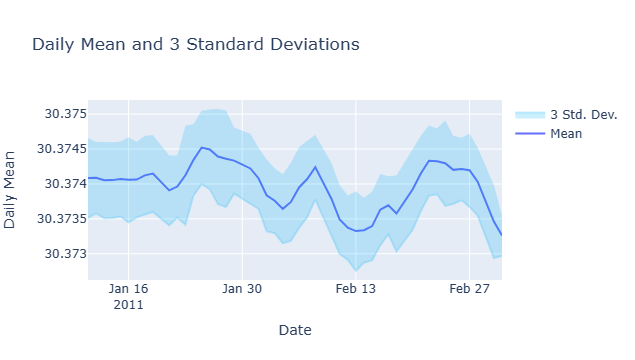

In [21]:
fig = go.Figure()

# Plot the mean line
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'], mode='lines', name='Mean'))

# # Plot the shaded area between the mean and 3 standard deviations
fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] + 3*frame['daily_stddev'], 
                         mode='lines', line=dict(color='rgba(0,0,0,0)'), showlegend=False))

fig.add_trace(go.Scatter(x=frame.index, y=frame['daily_mean'] - 3*frame['daily_stddev'], 
                         mode='lines', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', 
                         line=dict(color='rgba(0,176,246,0.2)'), name='3 Std. Dev.'))
# fill 指令，画出与上一个scatter line 之间的区域

# Add axis labels and titles
fig.update_layout(xaxis_title='Date', yaxis_title='Daily Mean', 
                  title='Daily Mean and 3 Standard Deviations')
fig.write_html()

In [9]:
#目前还缺了几天 （尴尬）

### eve digital features

In [23]:
np.std(frame['daily_mean'])

0.00033139365960962465

In [24]:
np.std(frame['daily_mean'])**2

1.0982175762945977e-07

In [25]:
np.var(frame['daily_mean'])

1.0982175762945978e-07

In [27]:
25*np.var(frame['daily_mean'])

2.7455439407364947e-06

# AIA

## 3 parameter result visualization
先不看常数项，即先忽略绝对波长，只看相对波长的变化

In [ ]:
aia_frame.index[0], aia_frame.index[-1]

In [38]:
frame.index

DatetimeIndex(['2011-01-11', '2011-01-12', '2011-01-13', '2011-01-14',
               '2011-01-15', '2011-01-16', '2011-01-17', '2011-01-18',
               '2011-01-19', '2011-01-21', '2011-01-22', '2011-01-23',
               '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
               '2011-01-28', '2011-01-29', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-10',
               '2011-02-11', '2011-02-12', '2011-02-13', '2011-02-14',
               '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18',
               '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23',
               '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27',
               '2011-02-28', '2011-03-02', '2011-03-03'],
              dtype='datetime64[ns]', name='date', freq=None)

In [26]:
def visual_3(a,d,e):
    # 调整至原点
    temp=get_aia_simu(a,  d, e)
    aia_simu_data={
                   'date':list(temp.keys()),
                   'daily_mean':list(temp.values()),
                    }
    aia_frame=pd.DataFrame(aia_simu_data)
    aia_frame=aia_frame.set_index('date')
    
    fig = go.Figure()
    # Plot the mean line
    fig.add_trace(go.Scatter(x=aia_frame.index, 
                             y=aia_frame['daily_mean']-np.mean(aia_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='red'),
                             name='AIA simulation'))
    
    # Plot the eve obs
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.9)'),
                             name='EVE obs: mean '))
    
    # # Plot the shaded area between the mean and 3 standard deviations
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] + 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             showlegend=False))
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] - 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             fill='tonexty', 
                             fillcolor='rgba(0,176,246,0.2)', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             name='EVE obs: 3 stddev'))
    # fill 指令，画出与上一个scatter line 之间的区域

    # Add axis labels and titles
    fig.update_layout(xaxis_title='Date', 
                      yaxis_title='Daily Mean (nm)', 
                      title={
                            'text': f'Observation And Simulation:\n a={a:.3e},d={d:.3e},e={e:.3e}',
                            
                            'x': 0.5,
                            'y': 0.9,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                      xaxis_range=[aia_frame.index[0], aia_frame.index[-1]],
                      # legend={'yanchor': 'bottom'},
                     )
                    
    fig.show()

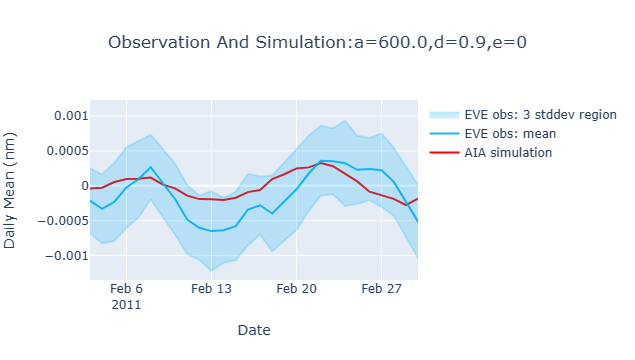

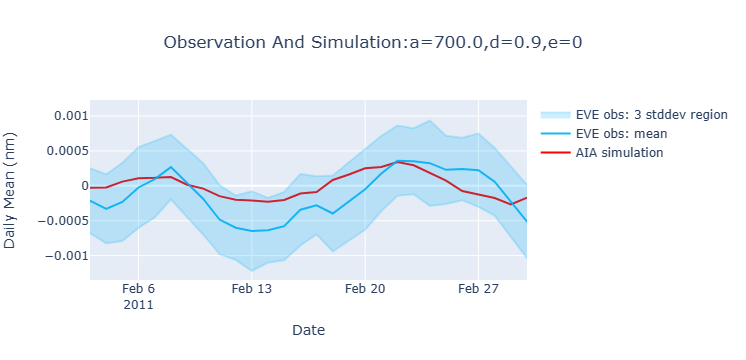

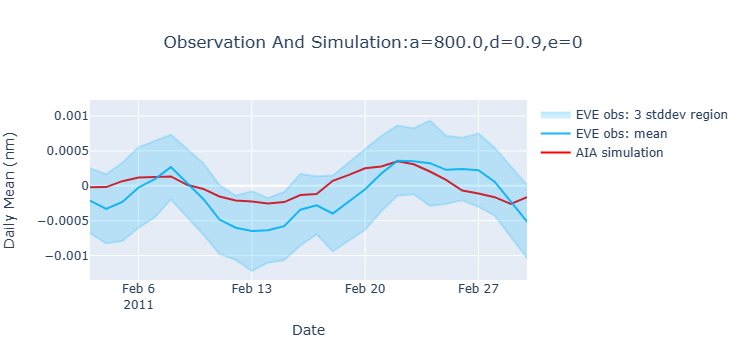

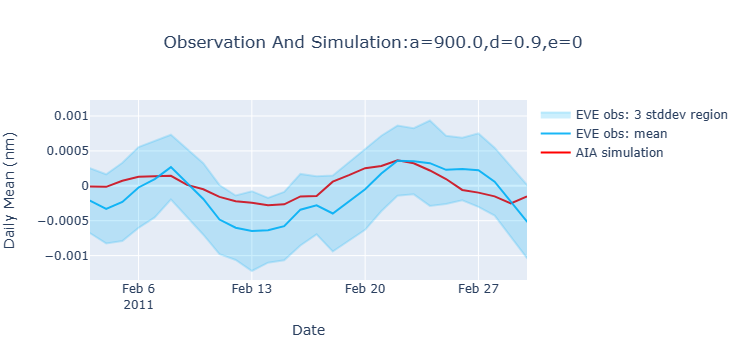

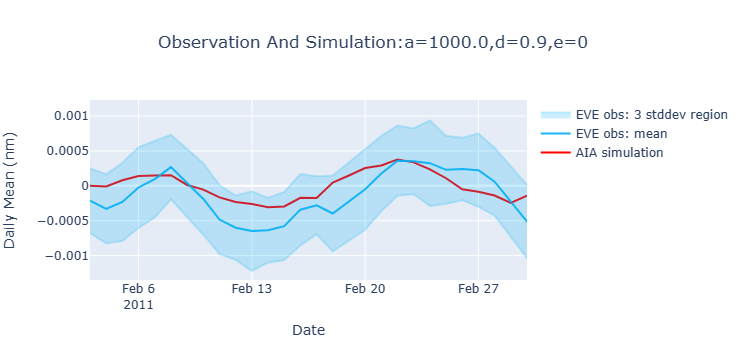

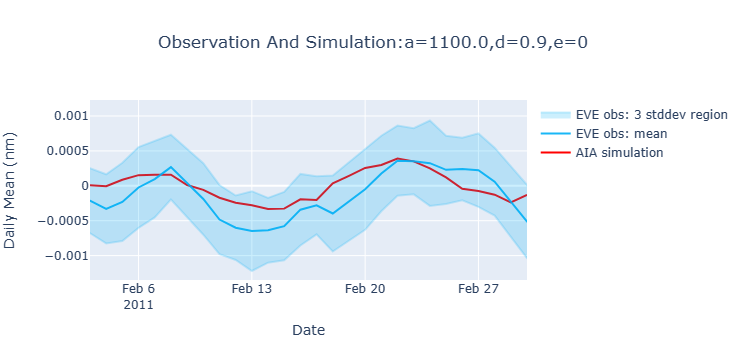

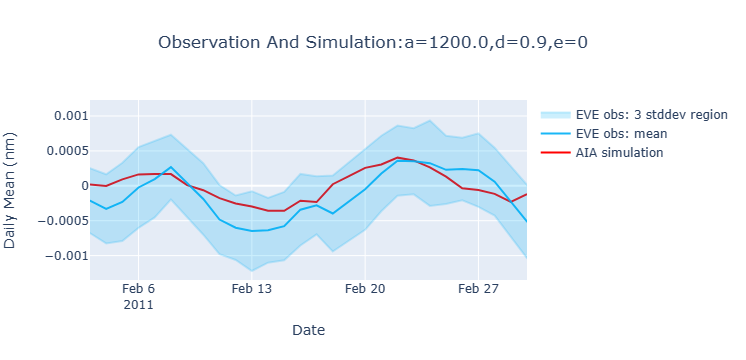

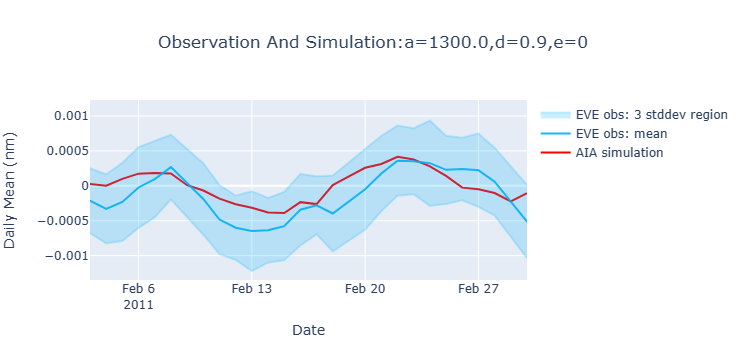

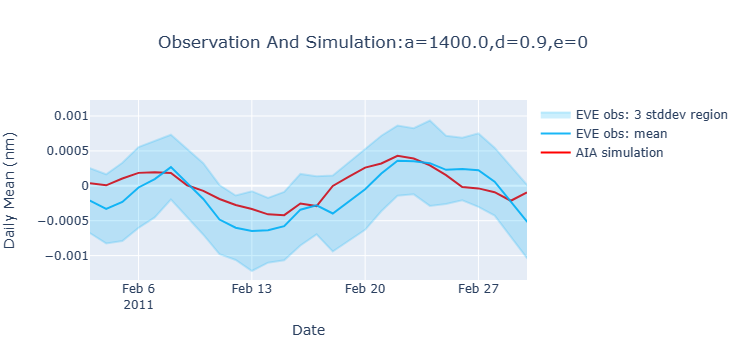

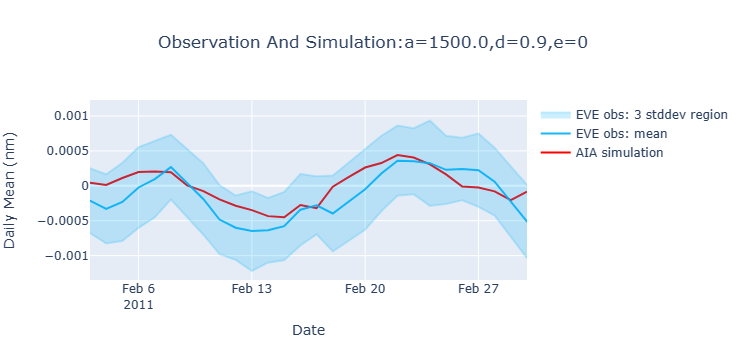

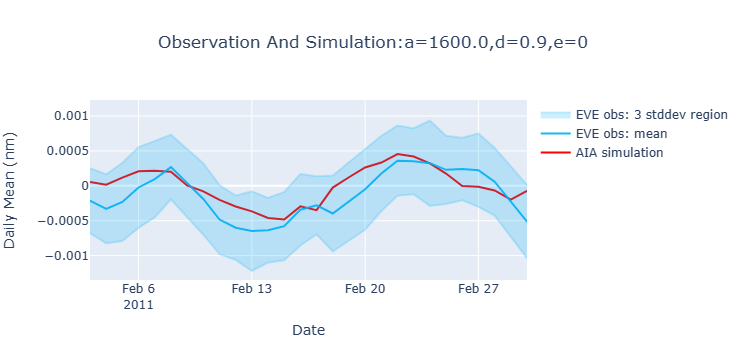

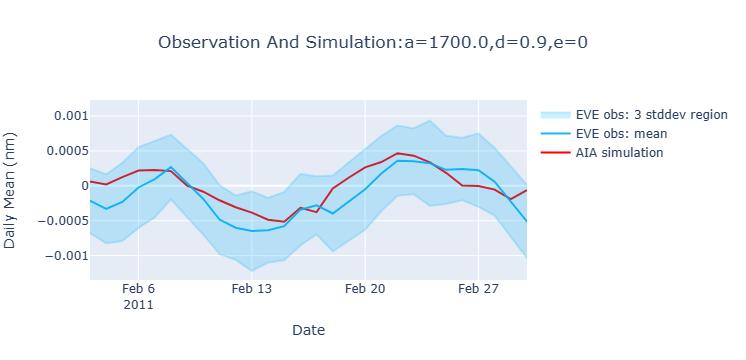

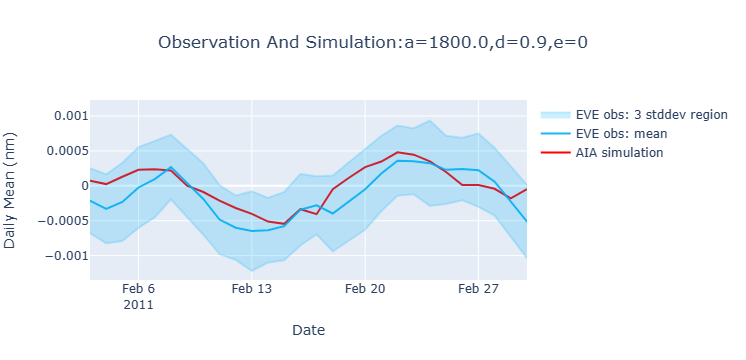

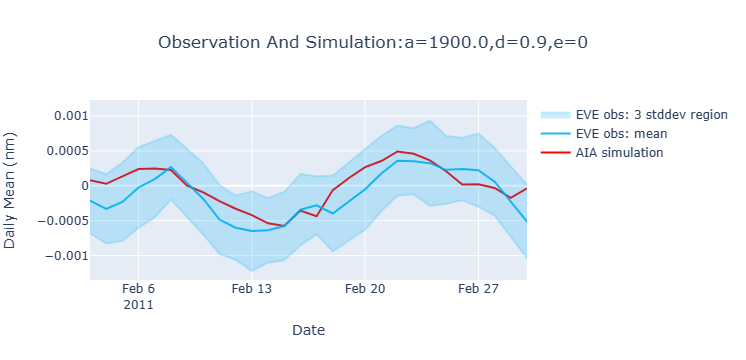

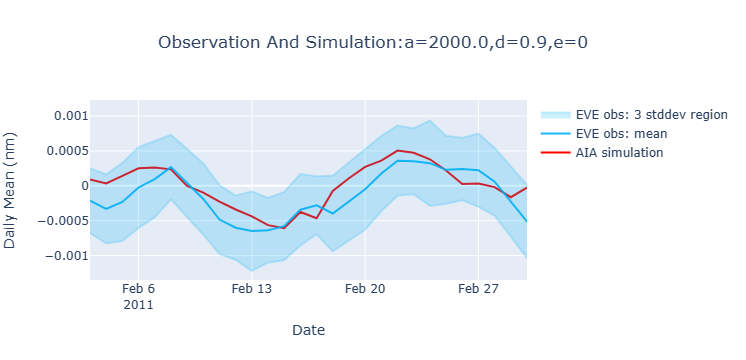

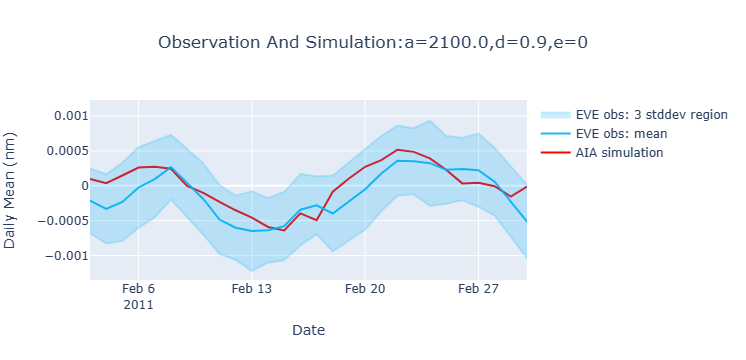

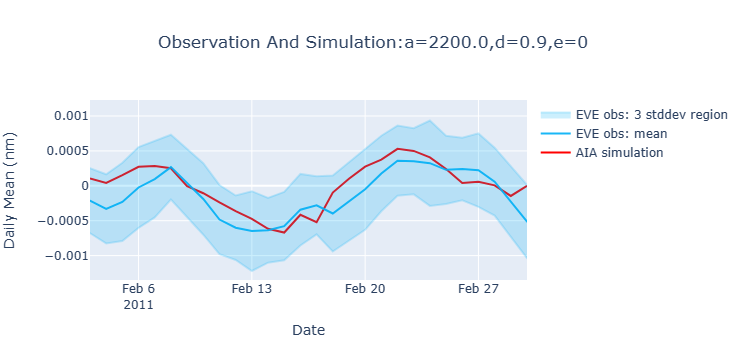

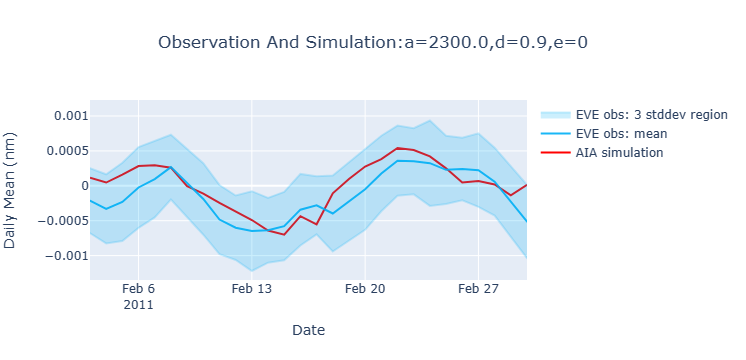

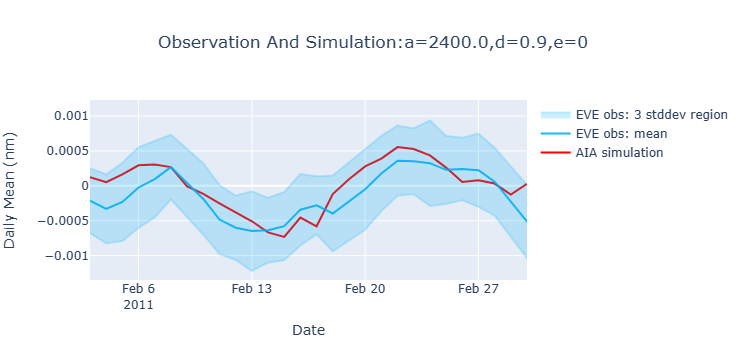

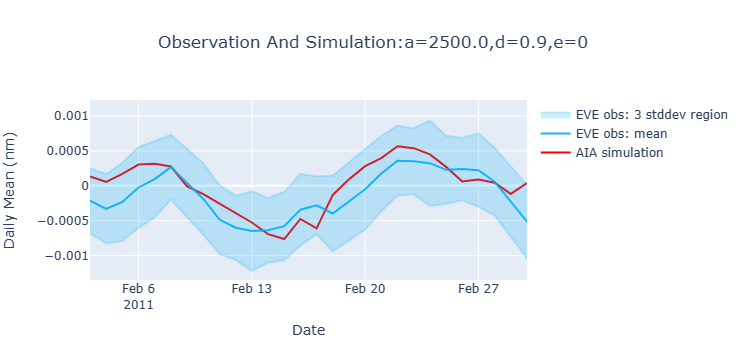

In [4]:
for a in np.linspace(600,2500,20):
    visual_3(a,.9,0)

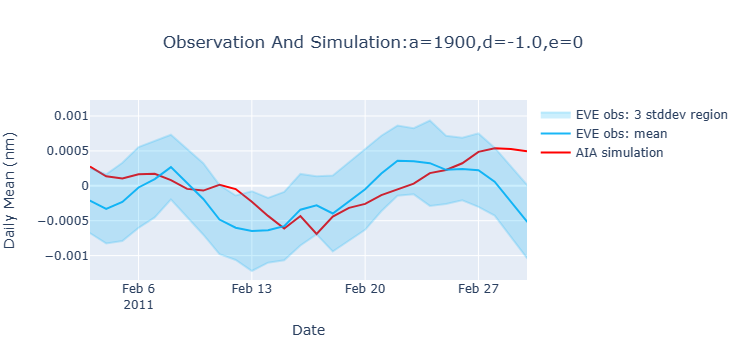

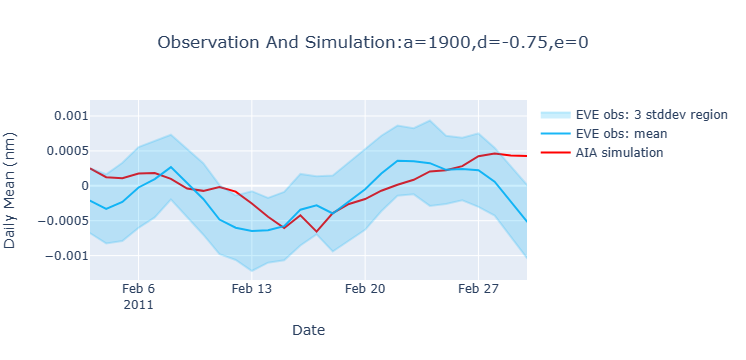

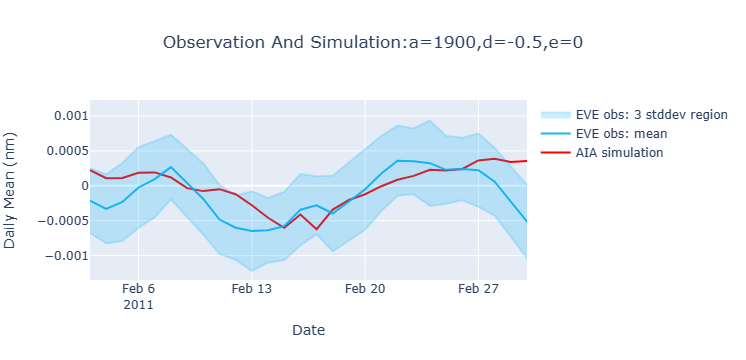

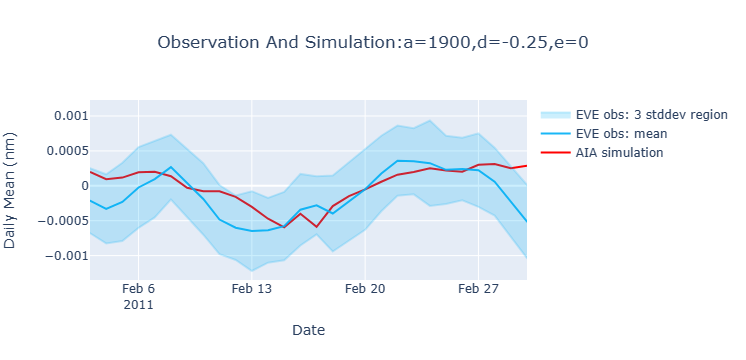

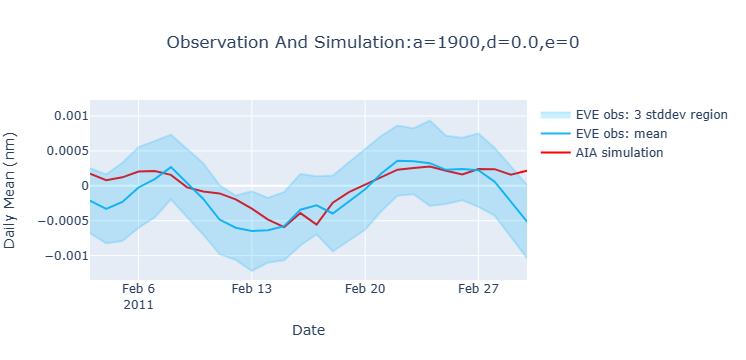

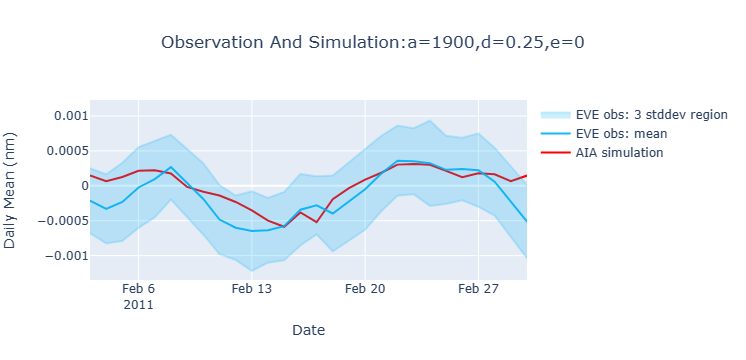

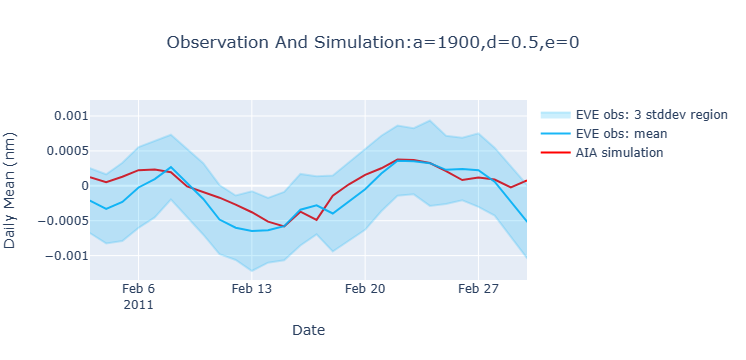

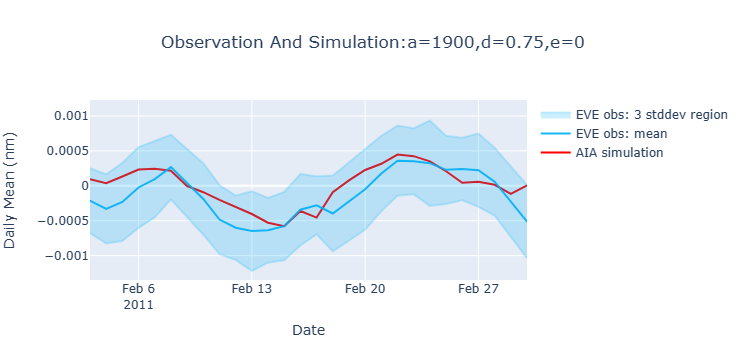

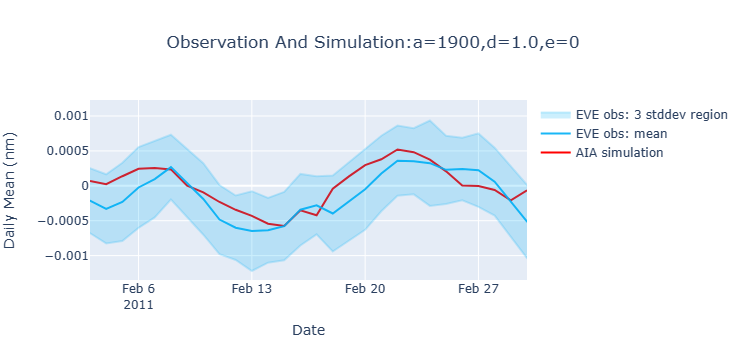

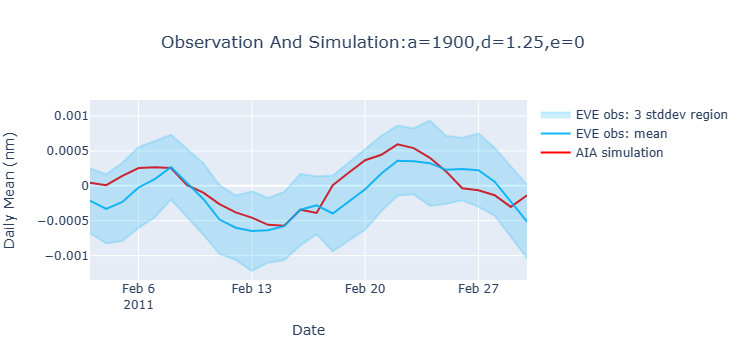

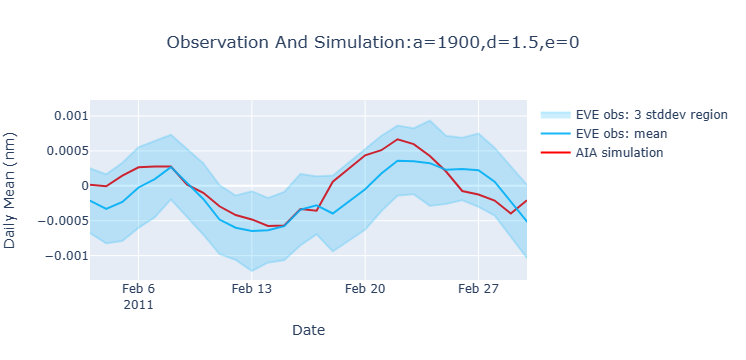

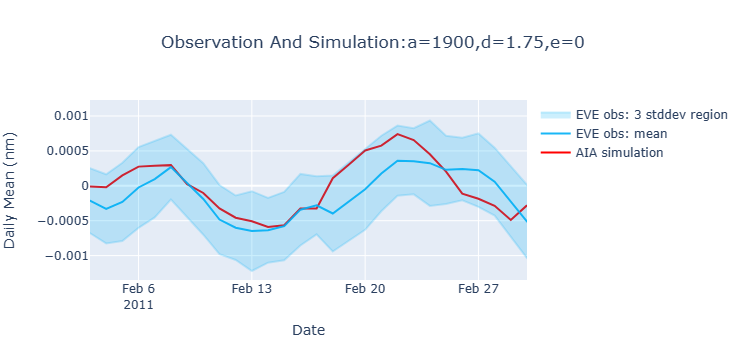

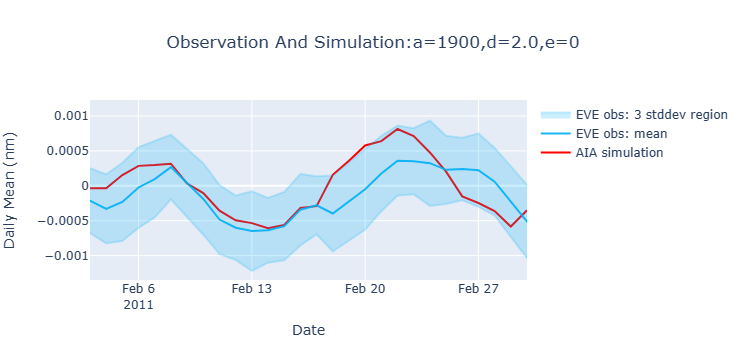

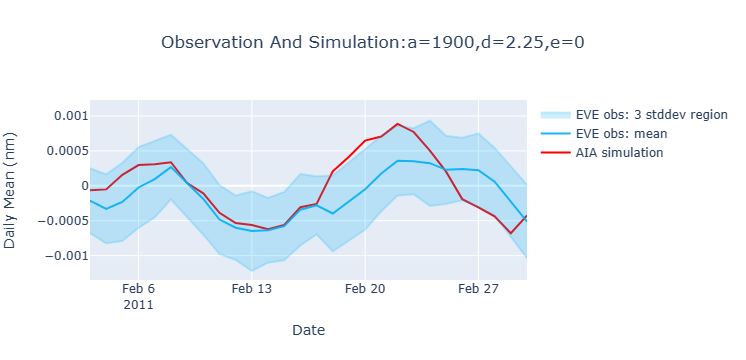

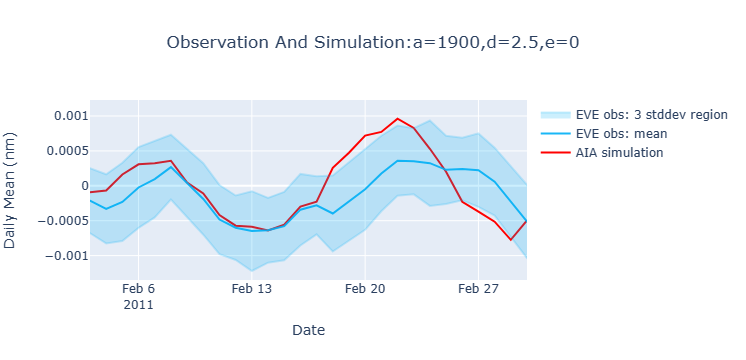

In [6]:
for b in np.linspace(-1,2.5,15):
    visual_3(1900,b,0)

In [7]:
error_function([1900,.9,0])

0.0054709521580078085

### optimal value

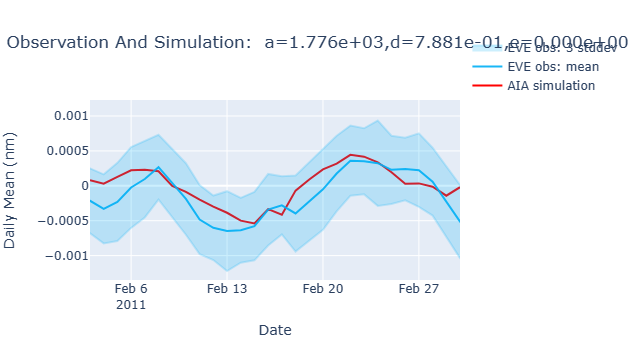

In [27]:
visual_3(1.77634512e+03 , 7.88081229e-01,0)

## 5 parameter result visualization

In [66]:
def visual_5(a,b,c,d,e):
    # 调整至原点
    temp=get_aia_simu_5(a, b,c, d, e)
    aia_simu_data={
                   'date':list(temp.keys()),
                   'daily_mean':list(temp.values()),
                    }
    aia_frame=pd.DataFrame(aia_simu_data)
    aia_frame=aia_frame.set_index('date')
    
    fig = go.Figure()
    # Plot the mean line
    fig.add_trace(go.Scatter(x=aia_frame.index, 
                             y=aia_frame['daily_mean']-np.mean(aia_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='red'),
                             name='AIA simulation'))
    
    # Plot the eve obs
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.9)'),
                             name='EVE obs: mean '))
    
    # # Plot the shaded area between the mean and 3 standard deviations
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] + 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             showlegend=False))
    fig.add_trace(go.Scatter(x=eve_frame.index, 
                             y=eve_frame['daily_mean'] - 3*eve_frame['daily_stddev']-np.mean(eve_frame['daily_mean']), 
                             mode='lines', 
                             fill='tonexty', 
                             fillcolor='rgba(0,176,246,0.2)', 
                             line=dict(color='rgba(0,176,246,0.2)'), 
                             name='EVE obs: 3 stddev'))
    # fill 指令，画出与上一个scatter line 之间的区域

    # Add axis labels and titles
    fig.update_layout(xaxis_title='Date', 
                      yaxis_title='Daily Mean (nm)', 
                      title={
                            'text': f'Observation And Simulation: a={a:.2e},b={b:.2e},c={c:.2e},d={d:.2e},e={e:.2e}',
                            
                            'x': 0.5,
                            'y': 0.9,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                      xaxis_range=[aia_frame.index[0], aia_frame.index[-1]],
                      # legend={'yanchor': 'bottom'},
                     )
                    
    fig.show()

In [67]:
visual_5(
    1.71108641e+03 ,
    -9.59331616e-01 ,
    1.79897519e+02 ,
    7.33133905e-01,0)

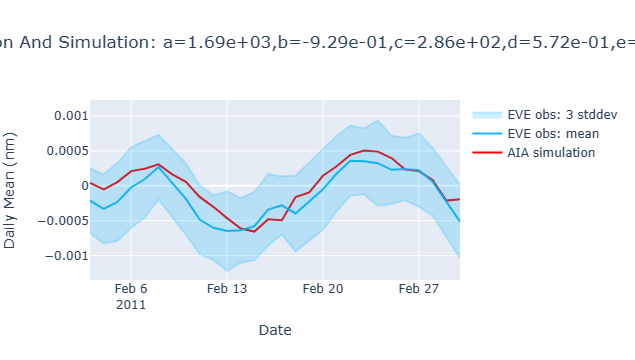

In [68]:
visual_5(1.69343153e+03,
         -9.29141603e-01,
         2.86354428e+02 ,
         5.72181265e-01,
         0)